In [1]:
import pandas as pd
import numpy as np
import torch

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('/data/ephemeral/home/output.csv')

In [3]:
df

,image_name,class,rle
0,image1661319116107.png,finger-1,1814994 8 1817040 13 1819085 19 1821131 25 182...
1,image1661319116107.png,finger-2,2077236 6 2079279 15 2081324 22 2083370 27 208...
2,image1661319116107.png,finger-3,2538138 6 2540183 12 2542228 17 2544275 19 254...
3,image1661319116107.png,finger-4,828115 10 830161 15 832206 22 834252 26 836299...
4,image1661319116107.png,finger-5,1082112 5 1084155 10 1086201 13 1088246 17 109...
...,...,...,...
8347,image1667354424553.png,Lunate,2884611 10 2886653 21 2888699 27 2890745 32 28...
8348,image1667354424553.png,Triquetrum,2794389 11 2796434 17 2798480 22 2800525 28 28...
8349,image1667354424553.png,Pisiform,2839461 10 2841505 20 2843550 25 2845595 29 28...
8350,image1667354424553.png,Radius,2968739 3 2970784 8 2972829 14 2974875 19 2976...


In [4]:
def rle_to_mask(rle, height, width):
    mask = np.zeros(height * width, dtype=np.uint8)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2] - 1
    lengths = array[1::2]
    for start, length in zip(starts, lengths):
        mask[start:start + length] = 1
    return mask.reshape((height, width))

In [5]:
def mask_to_poly_seg(mask):
    points = np.argwhere(mask == 1)
    points = points[:, [1, 0]]  # (row, col) => (x, y)
    return points.tolist()

In [6]:
height, width = 2048, 2048

In [7]:
# df['image_name'].unique()

In [8]:
import os
import json
from tqdm import tqdm

output_dir = '../data/fold3'
os.makedirs(output_dir, exist_ok=True)

poly_seg_data = []
for image_name in tqdm(df['image_name'].unique()):
    image_name_no_png = image_name.replace('.png', '')

    df2 = df[df['image_name'] == image_name]
    poly_seg_data = []
    for index, row in df2.iterrows():
        rle = row['rle']  
        mask = rle_to_mask(rle, height, width)
        points = mask_to_poly_seg(mask)
        poly_seg_data.append({
            "id": {},
            "type": "poly_seg",
            "attributes": {},
            "points": points,
            "label": row['class']
        })

    dict1 = {}
    dict1['annotations'] = poly_seg_data
    json_filename = os.path.join(output_dir, f"{image_name_no_png}.json")
    with open(json_filename, 'w', encoding='utf-8') as json_file:
        json.dump(dict1, json_file, ensure_ascii=False)


100%|██████████| 288/288 [11:21<00:00,  2.36s/it]


### visualization

In [9]:
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pycocotools import mask as coco_mask

In [10]:
image_path = "/data/ephemeral/home/level2-cv-semanticsegmentation-cv-06-lv3/data/fold_test_pseudo/images/image1661319116107.png"
label_path = "/data/ephemeral/home/level2-cv-semanticsegmentation-cv-06-lv3/data/fold3/annos/image1661319116107.json"

In [11]:
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

In [12]:
CLASS2IND = {v: i for i, v in enumerate(CLASSES)}

In [13]:
image = cv2.imread(image_path)
image = image / 255.

# (H, W, NC) 모양의 label을 생성합니다.
label_shape = tuple(image.shape[:2]) + (29, )
label = np.zeros(label_shape, dtype=np.uint8)

# label 파일을 읽습니다.
with open(label_path, "r") as f:
    annotations = json.load(f)
annotations = annotations["annotations"]

# 클래스 별로 처리합니다.
for ann in annotations:
    c = ann["label"]
    class_ind = CLASS2IND[c]
    points = np.array(ann["points"])
    
    # polygon 포맷을 dense한 mask 포맷으로 바꿉니다.
    class_label = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.fillPoly(class_label, [points], 1)
    label[..., class_ind] = class_label


# to tenser will be done later
image = image.transpose(2, 0, 1)    # channel first 포맷으로 변경합니다.
label = label.transpose(2, 0, 1)

image = torch.from_numpy(image).float()
label = torch.from_numpy(label).float()


In [14]:
# 시각화를 위한 팔레트를 설정합니다.
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

# 시각화 함수입니다. 클래스가 2개 이상인 픽셀을 고려하지는 않습니다.
def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image

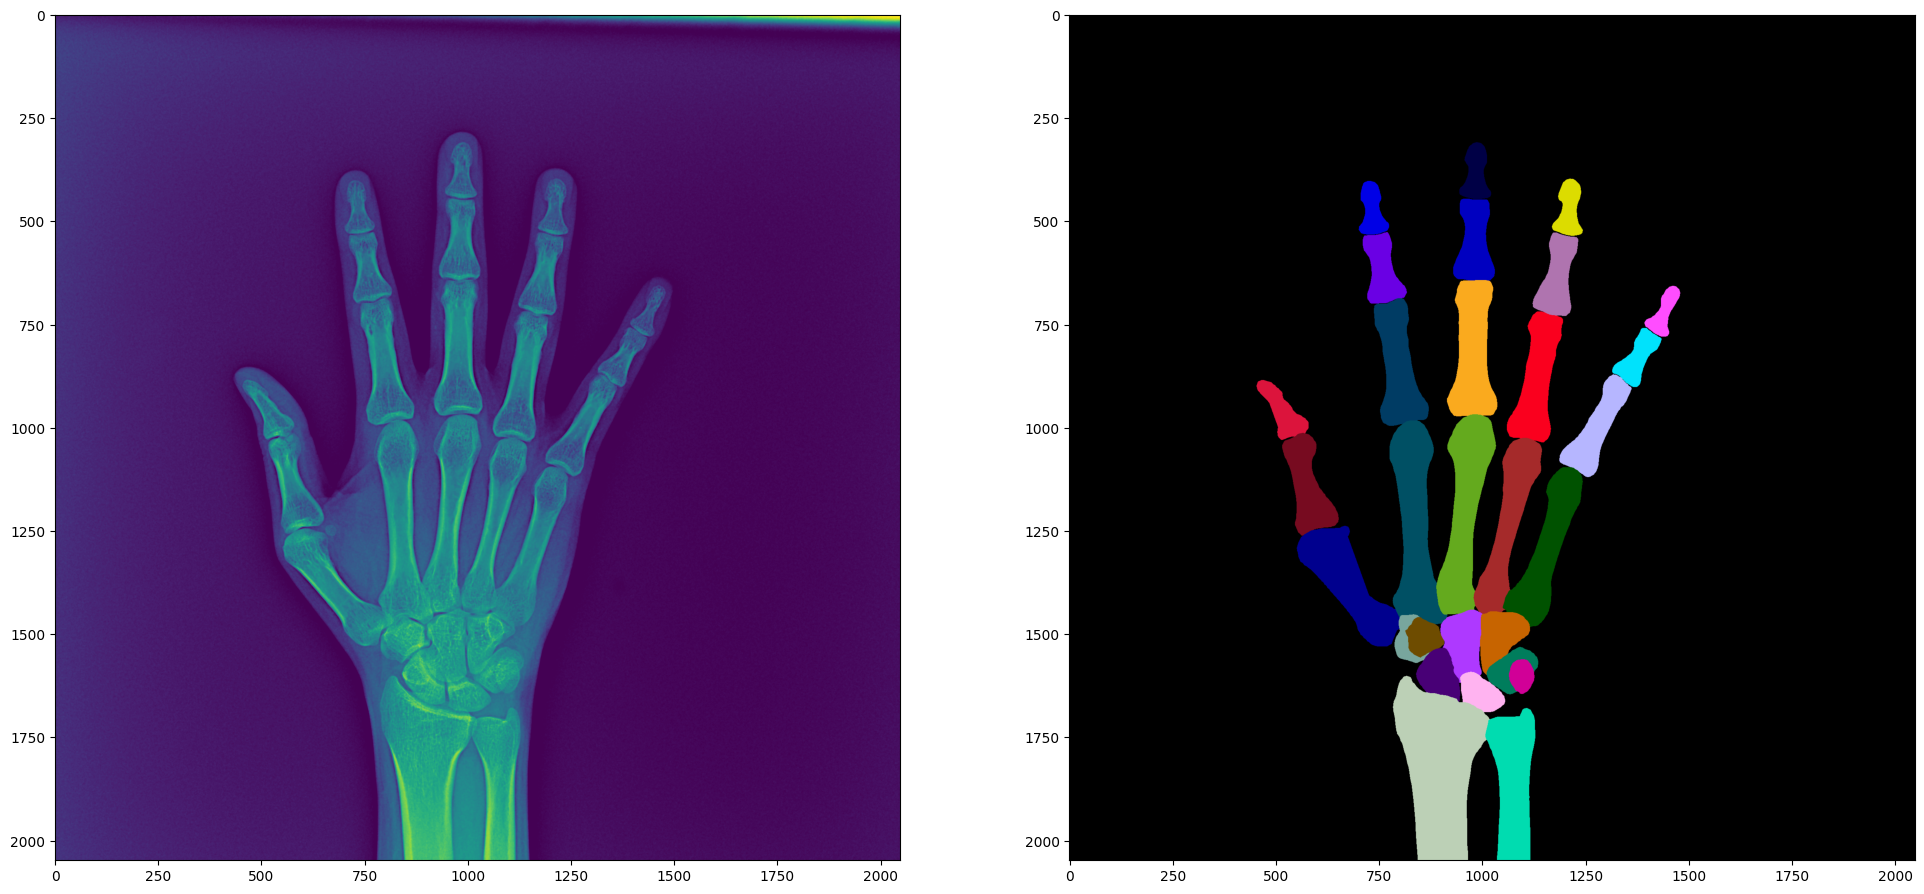

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].imshow(image[0])    # color map 적용을 위해 channel 차원을 생략합니다.
ax[1].imshow(label2rgb(label))

plt.show()